# Analyze modisco results for lung epithelial cell types

In [1]:
import numpy as np
import pandas as pd
import anndata
import h5py
import os
import scipy
import tqdm
import sys

from grelu.interpret.motifs import trim_pwm
from grelu.visualize import plot_attributions
from grelu.sequence.format import indices_to_strings

import seaborn as sns
from plotnine import *

sys.path.append('/code/decima/src/decima')
sys.path.append('.')

from motif_meta import clustername_mapping, bad_motifs

from matplotlib import pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Paths

In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823"
matrix_file = os.path.join(save_dir, "data.h5ad")
meme_file = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/H12CORE_meme_format.meme"
motif_json = '/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/H12CORE_annotation.jsonl'
motifcluster_path = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/data/jaspar/cluster/cluster_key.txt"

## Load data

In [3]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[ad.obs.organ.isin(['lung', 'airway'])]

## Subset to epithelial cell types

In [4]:
cts = ['respiratory basal cell','type II pneumocyte','type I pneumocyte','lung secretory cell',
      'club cell','ciliated cell','goblet cell']

In [5]:
ad = ad[ad.obs.cell_type.isin(cts)]

In [6]:
ad.obs.cell_type.value_counts()

cell_type
ciliated cell             77
club cell                 72
respiratory basal cell    61
type II pneumocyte        51
goblet cell               44
type I pneumocyte         42
lung secretory cell        5
Name: count, dtype: int64

## Load motif metadata

In [7]:
jsonObj = pd.read_json(motif_json, lines=True)
tf_to_family_dict = jsonObj[['name','masterlist_info']].set_index('name').to_dict()['masterlist_info']

In [8]:
motif_clusters = pd.read_csv(motifcluster_path, sep="\t",names=['cluster_name','hits'])
motif_clusters['hits'] = motif_clusters['hits'].apply(lambda x: x.split(','))
tf_to_motifcluster_dict = {}
for _,row in motif_clusters.iterrows():
    for hit in row['hits']:
        tf_to_motifcluster_dict[hit] = row['cluster_name']

## Match TOMTOM results to HOCOMOCO clusters

In [9]:
rows = []
for ct in cts:
    print(ct)
    ct_ = ct.replace(' ', '_')
    modisco_dir = f'lung_modisco/{ct_}'
    modisco_h5 = os.path.join(modisco_dir, f'{ct_}.h5')
    f = h5py.File(modisco_h5, 'r')
    for i in range(len(f['pos_patterns'])):
        num_seqlets = f['pos_patterns'][f'pattern_{i}']['seqlets']['n_seqlets'][0]
        row = {'cell_type':ct,'pattern':i,'count':num_seqlets}
        tomtom = pd.read_csv(os.path.join(modisco_dir,'tomtom',f"pos_patterns.pattern_{i}.tomtom.tsv"),sep="\t").dropna()
        tomtom = tomtom[tomtom['q-value'] < 0.05]
        if len(tomtom) > 0:
            target = tomtom.sort_values('q-value')['Target_ID'].iloc[0]
            top_target = tf_to_family_dict[target]['tf']
            top_cluster = tf_to_motifcluster_dict[target]
            if top_cluster in clustername_mapping:
                top_cluster = clustername_mapping[top_cluster]
            if top_target is not None:
                row['target'] = top_target
                row['cluster'] = top_cluster
                rows.append(row)
        
ct_motif_df = pd.DataFrame(rows)

respiratory basal cell
type II pneumocyte
type I pneumocyte
lung secretory cell
club cell
ciliated cell
goblet cell


## Drop uninformative motif clusters

In [10]:
cluster_sums = ct_motif_df.groupby('cluster')['count'].sum()
high_count_clusters = cluster_sums[cluster_sums > 500].index
ct_motif_df = ct_motif_df[ct_motif_df.cluster.isin(high_count_clusters)]

## Compute motif cluster enrichment per cell type

In [11]:
ct_cluster_df = ct_motif_df.groupby(['cell_type', 'cluster'])['count'].sum().reset_index()
seqlet_counts = ct_cluster_df.groupby('cell_type')['count'].sum().reset_index().set_index('cell_type').to_dict()['count']
ct_cluster_df = ct_cluster_df.sort_values(['cell_type','count'], ascending=False)
ct_cluster_df['total_count'] = ct_cluster_df['cell_type'].apply(lambda x: seqlet_counts[x])
ct_cluster_df['weight'] = ct_cluster_df['count']/ct_cluster_df['total_count']

In [13]:
ct_cluster_pivot = ct_cluster_df[['cell_type','cluster','weight']].pivot(
    index='cell_type', columns='cluster').fillna(0)
ct_cluster_pivot.columns = [x[1] for x in ct_cluster_pivot.columns]

In [14]:
ct_cluster_enr = ct_cluster_pivot/ct_cluster_pivot.mean(0)

## Visualize cluster enrichment per cell type

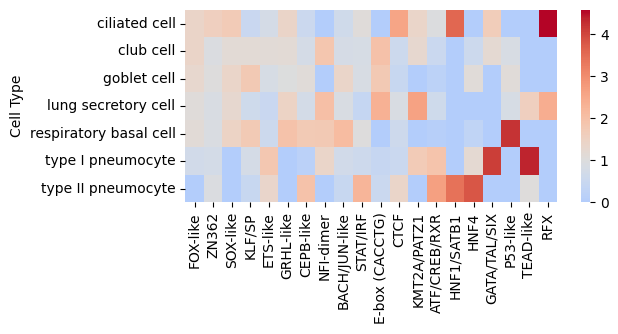

In [16]:
plt.figure(figsize=(6,2.5))
sns.heatmap(ct_cluster_enr.loc[:, ct_cluster_enr.max(0).sort_values().index], cmap='coolwarm', center=1)
plt.ylabel("Cell Type")
plt.show()

In [17]:
lineage_spec_order = pd.Series(np.vstack(
    [(ct_cluster_enr.iloc[:-2].min(0) - ct_cluster_enr.iloc[-2:].max(0)).values, (ct_cluster_enr.iloc[-2:].min(0) - ct_cluster_enr.iloc[:-2].max(0)).values]).max(0),
                               index=ct_cluster_enr.columns).sort_values().index

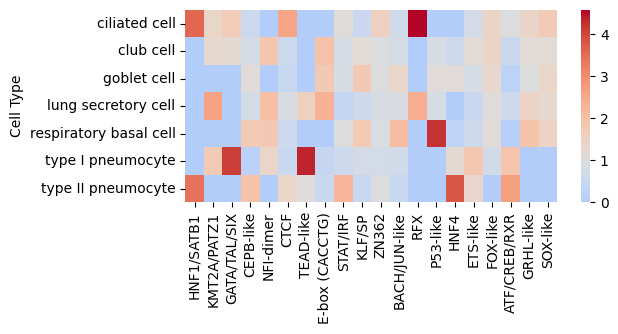

In [18]:
plt.figure(figsize=(6,2.5))
sns.heatmap(ct_cluster_enr.loc[:, lineage_spec_order], cmap='coolwarm', center=1)
plt.ylabel("Cell Type")
plt.show()

## Plot TF expression for top hits

In [20]:
ct_cluster_melt = ct_cluster_pivot.reset_index().melt(id_vars='cell_type', var_name='cluster', value_name='Motif\nweight')

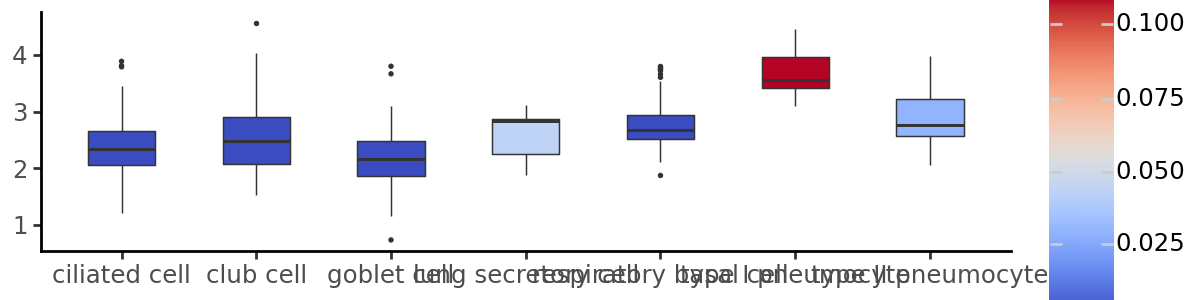

In [22]:
cluster_name = "TEAD-like"
tf_genes = ['TEAD1','TEAD2','TEAD3','TEAD4']
ad_sub = ad[:, ad.var.index.isin(tf_genes)].copy()
ad_sub.obs['expr'] = ad_sub.X.mean(1)
plot_df = ad_sub.obs.merge(ct_cluster_melt.query('cluster == @cluster_name'), on="cell_type")

(
    ggplot(plot_df, aes(x="cell_type", y="expr", fill='Motif\nweight')) 
    + geom_boxplot(outlier_size=.1, size=.3, width=.5) 
    + scale_fill_cmap('coolwarm', limits=(0, .11))
    + theme_classic() + theme(figure_size=(6, 1.5))
    + xlab("") + ylab("")
)

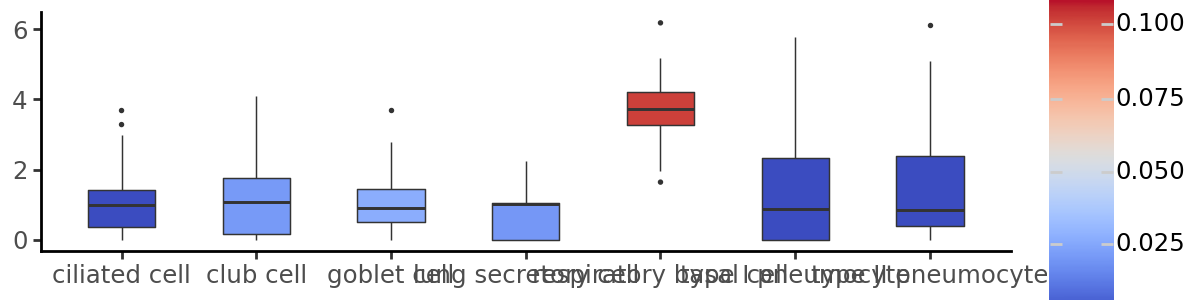

In [23]:
cluster_name = "P53-like"
tf_genes = ['TP63']
ad_sub = ad[:, ad.var.index.isin(tf_genes)].copy()
ad_sub.obs['expr'] = ad_sub.X.mean(1)
plot_df = ad_sub.obs.merge(ct_cluster_melt.query('cluster == @cluster_name'), on="cell_type")
(
    ggplot(plot_df, aes(x="cell_type", y="expr", fill='Motif\nweight')) 
    + geom_boxplot(outlier_size=.1, size=.3, width=.5) 
    + scale_fill_cmap('coolwarm', limits=(0, .11))
    + theme_classic() + theme(figure_size=(6, 1.5)) + xlab("") + ylab("")
)

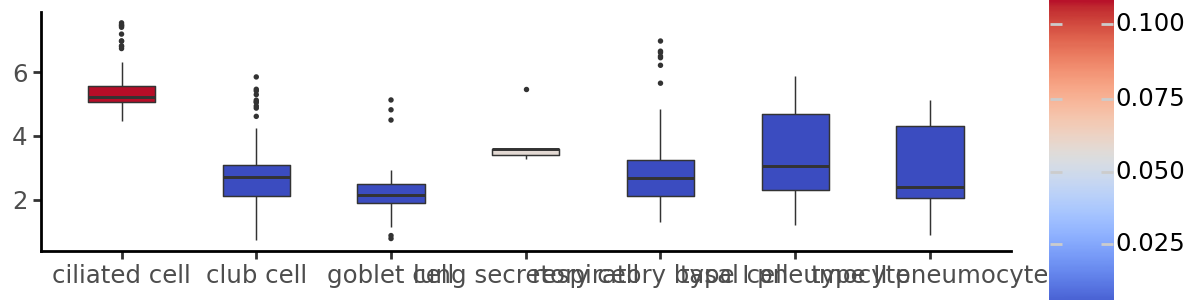

In [24]:
cluster_name = "RFX"
tf_genes = ['RFX2','RFX3']
ad_sub = ad[:,ad.var.index.isin(tf_genes)].copy()
ad_sub.obs['expr'] = ad_sub.X.mean(1)
plot_df = ad_sub.obs.merge(ct_cluster_melt.query('cluster == @cluster_name'), on="cell_type")
(
    ggplot(plot_df, aes(x="cell_type", y="expr", fill='Motif\nweight'))
    + geom_boxplot(outlier_size=.1, size=.3, width=.5)
    + scale_fill_cmap('coolwarm', limits=(0, .11))
    + theme_classic() + theme(figure_size=(6, 1.5)) +xlab("") + ylab("")
)

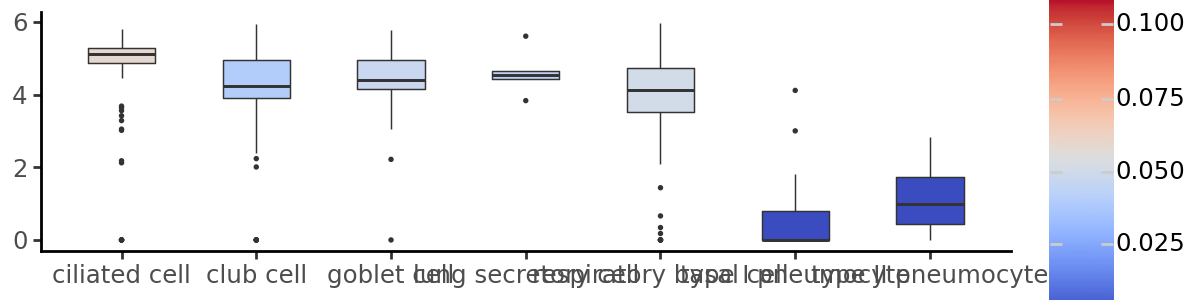

In [25]:
cluster_name = "SOX-like"
tf_genes = ['SOX2']
ad_sub = ad[:,ad.var.index.isin(tf_genes)].copy()
ad_sub.obs['expr'] = ad_sub.X.mean(1)
plot_df = ad_sub.obs.merge(ct_cluster_melt.query('cluster == @cluster_name'), on="cell_type")
(
    ggplot(plot_df, aes(x="cell_type", y="expr", fill='Motif\nweight')) 
    + geom_boxplot(outlier_size=.1, size=.3, width=.5) 
    + scale_fill_cmap('coolwarm', limits=(0, .11))
    + theme_classic() + theme(figure_size=(6, 1.5)) + xlab("") + ylab("")
)

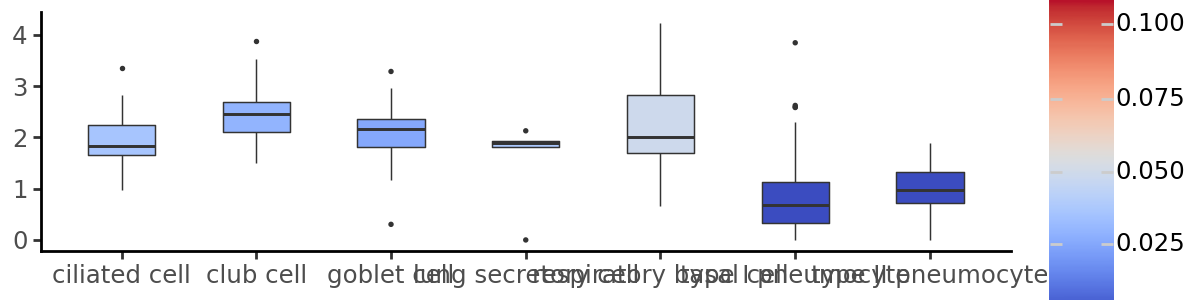

In [26]:
cluster_name = "GRHL-like"
tf_genes = ['GRHL1', 'GRHL3']
ad_sub = ad[:,ad.var.index.isin(tf_genes)].copy()
ad_sub.obs['expr'] = ad_sub.X.mean(1)
plot_df = ad_sub.obs.merge(ct_cluster_melt.query('cluster == @cluster_name'), on="cell_type")
(
    ggplot(plot_df, aes(x="cell_type", y="expr", fill='Motif\nweight')) 
    + geom_boxplot(outlier_size=.1, size=.3, width=.5) 
    + scale_fill_cmap('coolwarm', limits=(0, .11))
    + theme_classic() + theme(figure_size=(6, 1.5)) + xlab("") + ylab("")
)

## Plot motif logos from tf-modisco

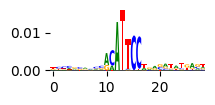

In [30]:
ct='type_I_pneumocyte'
i=1
modisco_h5 = f'lung_modisco/{ct}/{ct}.h5'
f = h5py.File(modisco_h5, 'r')
m = trim_pwm(np.array(f['pos_patterns'][f'pattern_{i}']['contrib_scores']), 0.1)
display(plot_attributions(m.T, figsize=(2,.8)))

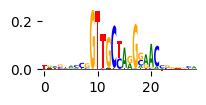

In [31]:
ct='ciliated_cell'
i=6
modisco_h5 = f'lung_modisco/{ct}/{ct}.h5'
f = h5py.File(modisco_h5, 'r')
m = trim_pwm(np.array(f['pos_patterns'][f'pattern_{i}']['contrib_scores']), 0.1)
s = indices_to_strings(m.argmax(1))
display(plot_attributions(m.T, figsize=(2,.8)))

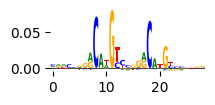

In [32]:
ct='respiratory_basal_cell'
i=2
modisco_h5 = f'lung_modisco/{ct}/{ct}.h5'
f = h5py.File(modisco_h5, 'r')
m = trim_pwm(np.array(f['pos_patterns'][f'pattern_{i}']['contrib_scores']), 0.1)
s = indices_to_strings(m.argmax(1))
display(plot_attributions(m.T, figsize=(2,.8)))

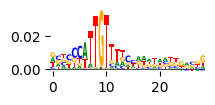

In [33]:
ct='ciliated_cell'
i=5
modisco_h5 = f'lung_modisco/{ct}/{ct}.h5'
f = h5py.File(modisco_h5, 'r')
m = trim_pwm(np.array(f['pos_patterns'][f'pattern_{i}']['contrib_scores']), 0.1)
display(plot_attributions(m.T, figsize=(2,.8)))